In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import xgboost as xgb 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

#https://www.datacamp.com/community/tutorials/xgboost-in-python 
#tutorial above to help create the model 

In [2]:
def get_datasets(std_size=False):
    # My python only likes absolute paths 
    brca = pd.read_csv('/Users/danielraad/Desktop/data/Gistic2_CopyNumber_BRCA', sep='\t')
    ovca = pd.read_csv('/Users/danielraad/Desktop/data/Gistic2_CopyNumber_OVCA', sep='\t')
    brca.set_index('Gene Symbol', inplace=True)
    ovca.set_index('Gene Symbol', inplace=True)
    brca = brca.transpose()
    ovca = ovca.transpose()
    brca['BRCA'] = 1
    ovca['BRCA'] = 0
    print('size brca, ovca', len(brca), len(ovca))
    if not std_size:
        print('normal size', len(brca)+len(ovca))
        df = pd.concat([brca, ovca[1:]])
    elif std_size:
        print('sampled size', len(ovca)+len(ovca))
        df = pd.concat([brca[0:len(ovca)], ovca[1:]])
    return df
df = get_datasets()

size brca, ovca 1080 579
normal size 1659


/Users/danielraad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
#seperate the target variable from the other variables
from sklearn.model_selection import train_test_split
X = df.drop(['BRCA'], axis = 1)
y = df['BRCA']
X_train, X_test, y_train, y_tests = train_test_split(X, y, test_size = 0.33)
y_red = pd.Series(y)
features = list(X_train.columns)

In [4]:
#XGBoost with PCA applied 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

x = 0.9999
pca = PCA(n_components=0.99)
pca.fit(X_train)
X_pca = pca.transform(X)
pca = PCA(n_components=x)
pca.fit(X_train)
X_pca = pca.transform(X)
print('at', x, '% of the variance ======')
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
y_red = pd.Series(y)

df_redd = pd.DataFrame(X_pca)

X_traind, X_testd, y_traind, y_testd = train_test_split(df_redd, y)

cfamodel = xgb.XGBClassifier()


cfamodel.fit(X_traind,y_traind)


ctrain_xg_predictions = cfamodel.predict(X_traind)
ctrain_xg_probs       = cfamodel.predict_proba(X_traind)[:, 1]


cxg_predictions = cfamodel.predict(X_testd)
cxg_probs       = cfamodel.predict_proba(X_testd)[:, 1]
features = list(X_traind.columns)
print(cxg_predictions)

at 0.9999 % of the variance ======
original shape:    (1658, 24776)
transformed shape: (1658, 996)
[1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1
 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0
 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0
 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0
 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0
 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1
 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1
 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0
 1 1 1 0 1 0 1 1]


In [5]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(cfamodel,df_redd,y_red,cv=10,scoring='accuracy')
print(scores.mean())

0.9547426067907996


In [7]:
#Top 10 features 
features = list(X_traind.columns)
fi_model = pd.DataFrame({'feature': features,
                   'importance': cfamodel.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
0,0,0.074662
25,25,0.026880
804,804,0.021567
321,321,0.015634
330,330,0.014939
331,331,0.014698
271,271,0.014465
465,465,0.014251
83,83,0.013242
35,35,0.013169


In [8]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[134  14]
 [ 10 257]]


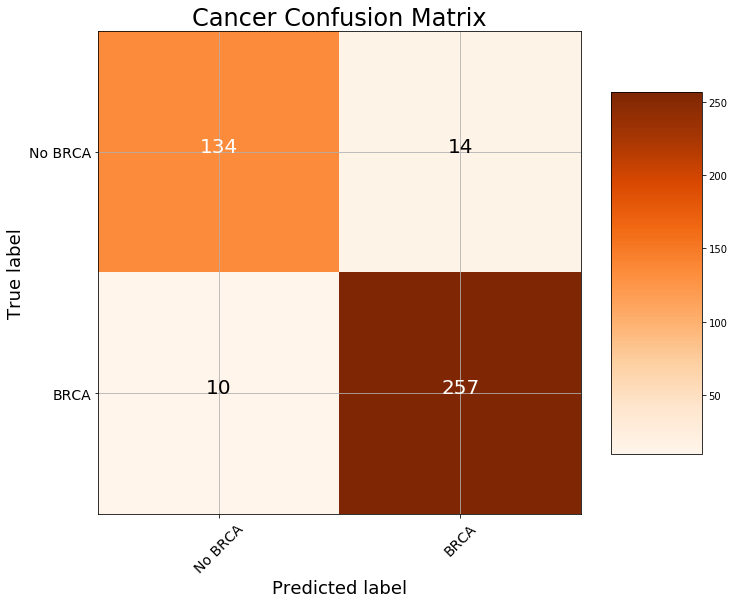

In [11]:
cm = confusion_matrix(y_testd, cxg_predictions)
plot_confusion_matrix(cm, classes = ['No BRCA', 'BRCA'],
                      title = 'Cancer Confusion Matrix')

In [12]:
accuracy = accuracy_score(y_testd, cxg_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.22%
